# Getting Started with PyTorch

Classifying CIFAR10 images using a CNN.
Built on the official [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).


## Loading the CIFAR10 Dataset

In [ ]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


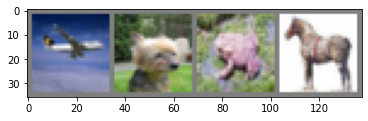

plane   dog  frog horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Building a CNN Model with PyTorch

Architecture:
* Input: 32x32-pixel images with 3 channels (RGB) &rarr; 3x32x32 images
* Convolutions with 3 input channels, 6 output channels, and 5x5 square convolution
&rarr; 6x28x28 images
* 2x2 max pooling (subsampling) &rarr; 6x14x14 images
* 6 input channels (from the previous Conv2d layer), 16 output channels, 5x5 square convolutions
&rarr; 16x10x10 images
* 2x2 max pooling (subsampling) &rarr; 16x5x5 images
* Fully connected linear (=dense) layer with `16x5x5=400` input size and 120 output; ReLU activation
* Fully connected layer with 120 input and 84 output; ReLU activation
* Fully connected output layer with 84 input and 10 output (for the 10 classes in the CIFAR10 dataset); no/linear activation

Note that the layers are defined in the constructor and the activations applied in the `forward` function.

To calculate the output size of a convolutional layer, use [this formula](https://stackoverflow.com/a/53580139/2745116):

$\frac{W−K+2P}{S} +1$ with input size $W$ (width and height for square images),
convolution size $K$, padding $P$ (default 0), and stride $S$ (default 1).

Further explanation on layer sizes: [Medium article by Jake Krajewski](https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd)


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [5]:
# loss and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

Over 5 epochs.

In [ ]:
# training
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Testing the Trained Model

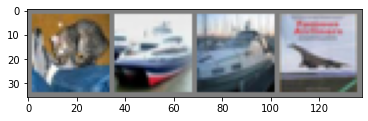

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [9]:
# load the saved model (just for show; it's already loaded)
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car truck plane


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 58 %
Accuracy of  bird : 48 %
Accuracy of   cat : 37 %
Accuracy of  deer : 30 %
Accuracy of   dog : 32 %
Accuracy of  frog : 70 %
Accuracy of horse : 68 %
Accuracy of  ship : 62 %
Accuracy of truck : 69 %
